# Coursework Template

**Dependencies and imports**

This can take a minute...

In [25]:
# !pip install swig
# !pip install --upgrade rldurham

In [26]:
import torch
import rldurham as rld

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque

# Agent model and related classes

## Memory Mangement

In [27]:
# Configuration class to store hyperparameters
class Config:
    GAMMA = 0.99  # Discount factor
    LAMBDA = 0.95  # GAE parameter
    BATCH_SIZE = 2048  # Batch size for training
    MEMORY_SIZE = 2048  # Size of memory buffer

class Memory:
    def __init__(self, state_size, action_size, batch_size):
        """Initialize memory buffer with pre-allocated tensors for efficiency"""
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = batch_size
        
        # Pre-allocate tensors for storing transitions
        self.states = torch.zeros(batch_size, state_size).to(self.device)
        self.actions = torch.zeros(batch_size, action_size).to(self.device)
        self.action_logprobs = torch.zeros(batch_size, action_size).to(self.device)
        self.new_states = torch.zeros(batch_size, state_size).to(self.device)
        self.rewards = torch.zeros(batch_size).to(self.device)
        self.dones = torch.zeros(batch_size).to(self.device)
        
        # Pre-allocate tensors for advantage estimation
        self.advantages = torch.zeros(batch_size + 1).to(self.device)
        self.gt = torch.zeros(batch_size + 1).to(self.device)
        self.old_value_state = torch.zeros(batch_size).to(self.device)

    def add(self, state, action, actions_logprob, new_state, reward, done, n_batch_step):
        """Add a transition to memory at specified batch step"""
        self.states[n_batch_step] = torch.FloatTensor(state).to(self.device)
        self.actions[n_batch_step] = torch.FloatTensor(action).to(self.device)
        self.action_logprobs[n_batch_step] = actions_logprob.detach()
        self.new_states[n_batch_step] = torch.FloatTensor(new_state).to(self.device)
        self.rewards[n_batch_step] = torch.FloatTensor([reward]).squeeze(-1).to(self.device)
        self.dones[n_batch_step] = torch.FloatTensor([int(done)]).squeeze(-1).to(self.device)
        
    def calculate_gae_advantage(self, values, next_values):
        """Calculate GAE advantages and returns for the entire batch"""
        self.gt[self.batch_size] = next_values[-1]
        
        for i in reversed(range(self.batch_size)):
            # Calculate TD error
            delta = (self.rewards[i] + 
                    Config.GAMMA * next_values[i] * (1 - self.dones[i]) - 
                    values[i])
            
            # Calculate GAE advantage
            self.advantages[i] = (delta + 
                                Config.LAMBDA * Config.GAMMA * 
                                self.advantages[i+1] * (1 - self.dones[i]))
            
            # Calculate returns for critic
            self.gt[i] = (self.rewards[i] + 
                         Config.GAMMA * self.gt[i+1] * (1 - self.dones[i]))

## Agent

In [28]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
from collections import deque
import copy

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size=400):
        super(ActorCritic, self).__init__()
        
        # Shared feature extractor with layer normalization
        self.feature_extractor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.Tanh()
        )
        
        # Separate policy and value networks to prevent interference
        self.policy_network = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.LayerNorm(hidden_size // 2),
            nn.Tanh()
        )
        
        self.value_network = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.LayerNorm(hidden_size // 2),
            nn.Tanh()
        )
        
        # Policy head with careful initialization
        self.policy_mean = nn.Linear(hidden_size // 2, num_outputs)
        torch.nn.init.uniform_(self.policy_mean.weight, -1e-3, 1e-3)
        torch.nn.init.uniform_(self.policy_mean.bias, -1e-3, 1e-3)
        
        self.value = nn.Linear(hidden_size // 2, 1)

    def forward(self, state):
        features = self.feature_extractor(state)
        policy_features = self.policy_network(features)
        value_features = self.value_network(features)
        
        # Use tanh to bound actions to [-1, 1]
        action_mean = torch.tanh(self.policy_mean(policy_features))
        state_value = self.value(value_features)
        
        return action_mean, state_value

class PPOAgent:
    def __init__(self, num_inputs, num_outputs, hidden_size=400, lr=2e-4):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        
        # Initialize actor-critic network and target network
        self.ac_net = ActorCritic(num_inputs, num_outputs, hidden_size).to(self.device)
        self.target_net = copy.deepcopy(self.ac_net)
        
        # Initialize optimizer with learning rate scheduling
        self.optimizer = optim.Adam(self.ac_net.parameters(), lr=lr)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='max', factor=0.5, patience=100, min_lr=1e-5
        )
        
        # Initialize memory buffer
        self.memory = Memory(num_inputs, num_outputs, Config.MEMORY_SIZE)
        self.batch_step = 0
        
        # Initialize exploration parameters
        self.action_std = 0.5
        self.min_action_std = 0.1
        self.action_std_decay_rate = 0.02
        self.action_std_decay_freq = 300
        
        # Performance tracking
        self.rewards_history = deque(maxlen=200)
        self.episode_count = 0
        self.best_average_reward = float('-inf')
        self.no_improvement_count = 0
        
        # Policy averaging parameter
        self.policy_alpha = 0.995

    def sample_action(self, state):
        """Sample action using current policy with noise and ensure correct format for BipedalWalker"""
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            # Use target network for stable action selection
            action_mean, _ = self.target_net(state_tensor)
            
            # Add controlled noise for exploration
            std = torch.full_like(action_mean, self.action_std)
            dist = Normal(action_mean, std)
            action = dist.sample()
            
            # Calculate log probability for training
            log_prob = dist.log_prob(action)
            
            # Convert action to numpy and ensure it's the right shape
            # BipedalWalker expects a 1D array of 4 elements
            action_np = action.cpu().numpy().flatten()
            
            # Store log_prob for later use in training
            self.last_log_prob = log_prob
            
            return action_np  # Return just the action for the environment

    def step(self, state, action, next_state, reward, done):
        """Process a single environment step"""
        # Add transition to memory using the stored log_prob
        self.memory.add(state, action, self.last_log_prob, next_state, reward, done, self.batch_step)
        self.batch_step += 1
        
        # Train if memory is full
        if self.batch_step >= Config.BATCH_SIZE:
            self.train()
            self.batch_step = 0
            return True
            
        return False

    def train(self):
        """Train the agent using collected experiences"""
        # Get current values and next values
        with torch.no_grad():
            _, values = self.ac_net(self.memory.states)
            _, next_values = self.target_net(self.memory.new_states)
            values = values.squeeze()
            next_values = next_values.squeeze()
        
        # Calculate advantages using GAE
        self.memory.calculate_gae_advantage(values, next_values)
        
        # Normalize advantages
        advantages = self.memory.advantages[:Config.BATCH_SIZE]
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # Multiple epochs of training
        for _ in range(8):  # Number of training epochs
            # Get updated predictions
            action_means, new_values = self.ac_net(self.memory.states)
            
            # Calculate new action probabilities
            dist = Normal(action_means, torch.full_like(action_means, self.action_std))
            new_log_probs = dist.log_prob(self.memory.actions).sum(dim=-1)
            
            # Calculate policy ratio
            ratio = torch.exp(new_log_probs - self.memory.action_logprobs.sum(dim=-1))
            
            # Calculate policy loss using clipped objective
            policy_loss = -torch.min(
                ratio * advantages,
                torch.clamp(ratio, 1 - 0.2, 1 + 0.2) * advantages
            ).mean()
            
            # Calculate value loss
            value_loss = 0.5 * ((new_values.squeeze() - self.memory.gt[:Config.BATCH_SIZE]) ** 2).mean()
            
            # Calculate entropy bonus for exploration
            entropy_loss = -dist.entropy().mean()
            
            # Combine losses
            total_loss = (
                policy_loss + 
                0.5 * value_loss + 
                0.01 * entropy_loss
            )
            
            # Perform optimization step
            self.optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.ac_net.parameters(), 0.5)
            self.optimizer.step()
        
        # Soft update target network
        self._soft_update_target_network()

    def _soft_update_target_network(self):
        """Soft update target network parameters"""
        for target_param, param in zip(self.target_net.parameters(), self.ac_net.parameters()):
            target_param.data.copy_(
                self.policy_alpha * target_param.data + 
                (1.0 - self.policy_alpha) * param.data
            )

    def update_stats(self, episode_reward):
        """Update agent statistics and adjust exploration"""
        self.rewards_history.append(episode_reward)
        self.episode_count += 1
        
        # Calculate current performance
        current_avg = np.mean(list(self.rewards_history)[-20:])
        
        # Update learning rate based on performance
        self.scheduler.step(current_avg)
        
        # Update best performance tracking
        if current_avg > self.best_average_reward:
            self.best_average_reward = current_avg
            self.no_improvement_count = 0
        else:
            self.no_improvement_count += 1
        
        # Decay exploration if performance is improving
        if (self.episode_count % self.action_std_decay_freq == 0 and 
            current_avg > -100 and self.no_improvement_count < 50):
            self.action_std = max(
                self.min_action_std,
                self.action_std - self.action_std_decay_rate
            )

    def reset(self):
        """Reset episode-specific parameters"""
        if self.batch_step >= Config.BATCH_SIZE:
            self.train()
            self.batch_step = 0
            
    

**Prepare the environment and wrap it to capture statistics, logs, and videos**

The device is: cpu (as recommended)
actions are continuous with 4 dimensions/#actions
observations are continuous with 24 dimensions/#observations
maximum timesteps is: None


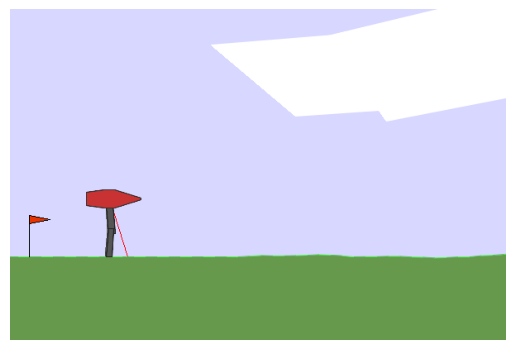

In [29]:
env = rld.make("rldurham/Walker", render_mode="rgb_array")
# env = rld.make("rldurham/Walker", render_mode="rgb_array", hardcore=True) # only attempt this when your agent has solved the non-hardcore version

# get statistics, logs, and videos
env = rld.Recorder(
    env,
    smoothing=10,                       # track rolling averages (useful for plotting)
    video=True,                         # enable recording videos
    video_folder="videos",              # folder for videos
    video_prefix="xxxx00-agent-video",  # prefix for videos (replace xxxx00 with your username)
    logs=True,                          # keep logs
)

# training on CPU recommended
rld.check_device()

# environment info
discrete_act, discrete_obs, act_dim, obs_dim = rld.env_info(env, print_out=True)

# render start image
env.reset(seed=42)
rld.render(env)

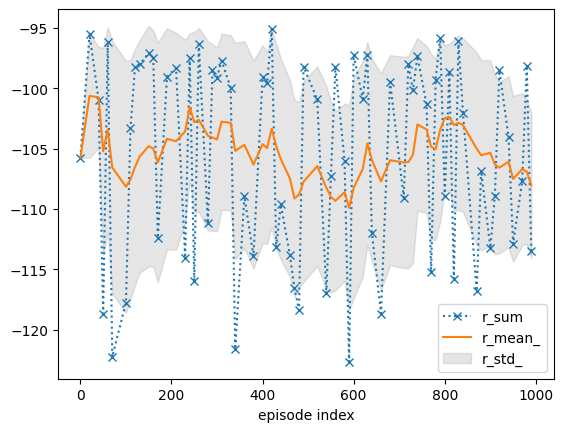

In [30]:
# Seed everything for reproducibility
seed, observation, info = rld.seed_everything(42, env)

# Initialize agent with the correct input/output dimensions
agent = PPOAgent(
    num_inputs=env.observation_space.shape[0],
    num_outputs=env.action_space.shape[0],
    hidden_size=400,  # Keeping the same architecture as before
    lr=2e-4  # Learning rate from the original implementation
)

# Training parameters
max_episodes = 1000
max_timesteps = 2000

# Initialize statistics tracker
tracker = rld.InfoTracker()

# Initially disable video recording for speed
env.video = False

for episode in range(max_episodes):
    # Configure environment recording settings
    env.info = episode % 10 == 0  # Record info every 10 episodes
    env.video = episode % 10 == 0  # Record video every 10 episodes
    
    # Reset environment and get initial observation
    current_observation, info = env.reset()
    episode_reward = 0
    
    # Reset agent's episode-specific parameters
    agent.reset()
    
    # Run episode
    for t in range(max_timesteps):
        # Sample action from the agent's policy
        action = agent.sample_action(current_observation)
        
        # Take step in environment
        next_observation, reward, terminated, truncated, info = env.step(action)
        
        # Store transition in agent's memory and check if we should train
        # Note: step() now returns whether training occurred
        did_train = agent.step(
            state=current_observation,
            action=action,
            next_state=next_observation,
            reward=reward,
            done=terminated or truncated
        )
        
        # Update episode reward
        episode_reward += reward
        
        # Update current observation
        current_observation = next_observation
        
        # End episode if done
        if terminated or truncated:
            break
    
    # Update agent statistics with episode results
    agent.update_stats(episode_reward)
    
    # Print progress every 10 episodes
    if episode % 10 == 0:
        # Calculate metrics for logging
        current_avg = np.mean(list(agent.rewards_history)[-20:])
        print(f"Episode {episode+1}, Reward: {episode_reward:.2f}, "
              f"Avg Reward: {current_avg:.2f}, "
              f"Action STD: {agent.action_std:.3f}")
    
    # Track and plot statistics
    tracker.track(info)
    if (episode + 1) % 10 == 0:
        tracker.plot(
            r_mean_=True,  # Plot mean reward
            r_std_=True,   # Plot reward standard deviation
            r_sum=dict(linestyle=':', marker='x')  # Plot sum with custom style
        )

# Clean up
env.close()

# Write log file
env.write_log(folder="logs", file="xxxx00-agent-log.txt")

A small demo with a predefined heuristic that is suboptimal and has no notion of balance (and is designed for the orignal BipedalWalker environment)...

In [31]:
from gymnasium.envs.box2d.bipedal_walker import BipedalWalkerHeuristics

env = rld.make(
    "rldurham/Walker",
    # "BipedalWalker-v3",
    render_mode="human",
    # render_mode="rgb_array",
    hardcore=False,
    # hardcore=True,
)
_, obs, info = rld.seed_everything(42, env)

heuristics = BipedalWalkerHeuristics()

act = heuristics.step_heuristic(obs)
for _ in range(500):
    obs, rew, terminated, truncated, info = env.step(act)
    act = heuristics.step_heuristic(obs)
    if terminated or truncated:
        break
    if env.render_mode == "rgb_array":
        rld.render(env, clear=True)
env.close()

Seed set to 42
